In this notebook we run a 3 layer CNN deblender and analyze the results 

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from __future__ import division
scripts = os.path.join(os.path.dirname(os.getcwd()), "scripts")
sys.path.insert(0, scripts)
import basic_net_utils as utils

In [5]:
def load_data(filename):
    train_data = np.load(filename)
    X_train = train_data['X_train']
    Y_train = train_data['Y_train']
    X_val = train_data['X_val']
    Y_val = train_data['Y_val']
    return X_train, Y_train, X_val, Y_val


def save_diff_blend(pred, Y_val):
    path = os.path.join(os.path.dirname(os.getcwd()), "data")
    filename = os.path.join(path, 'diff')
    diff = (Y_val - pred)
    diff_val =np.sum(np.sum(diff[:,:,:,0], axis=1), axis=1)
    np.save(filename, diff_val)
    return diff_val


from matplotlib.colors import LogNorm
def get_rgb(im):
    min_val = [np.min(im[:,:,i]) for i in range(3)]
    new_im = [np.sqrt(im[:,:,i] + min_val[i]) for i in range(3)]
    norm = np.max(new_im)
    new_im = [new_im[i].T/norm * 255 for i in range(3)]
    new_im = np.array(new_im, dtype='u1')
    return new_im.T

def plot_preds(pred, X_val, Y_val):
    for num in range(0, 10):
        plt.figure(figsize=[10, 6])
        plt.subplot(4, 4, 1)
        color_im = get_rgb(X_val[num, :, :, :])
        plt.imshow(color_im,norm=LogNorm(vmin=0, vmax=np.max(color_im)-10*np.std(color_im)))
        plt.title('Input blend (g, r, i)')
        plt.subplot(4, 4, 3)
        plt.imshow(pred[num, :, :, 0])
        plt.colorbar()
        plt.title('Network output')
        plt.subplot(4, 4, 2)
        plt.imshow(Y_val[num, :, :, 0])
        plt.colorbar()
        plt.title('Input central galaxy (i)')
        plt.subplot(4, 4, 4)
        plt.imshow(Y_val[num, :, :, 0]- pred[num, :, :, 0])
        plt.colorbar()
        plt.title('input - output')
        plt.show()


In [3]:
run_ident = 'test_3filter'

# Load data
path = os.path.join(os.path.dirname(os.getcwd()), "data")
filename = os.path.join(path, 'training_data.npz')
X_train, Y_train, X_val, Y_val = load_data(filename)

# Load CNN deblender
model = utils.CNN_deblender(run_ident=run_ident)

# Run model
run_params = utils.Meas_args(epochs=100, batch_size=32)
train_loss, val_loss, pred = model.run_basic(X_train, Y_train,
                                             run_params, X_val, Y_val)
model.save()
model.sess.close()

Iteration 0: with minibatch training loss = 17.682926178
Iteration 100: with minibatch training loss = 0.640607774258
Iteration 200: with minibatch training loss = 0.297641992569
Iteration 300: with minibatch training loss = 0.222575053573
Iteration 400: with minibatch training loss = 0.175422802567
Iteration 500: with minibatch training loss = 0.093158647418
Iteration 600: with minibatch training loss = 0.479488521814
Iteration 700: with minibatch training loss = 0.261793553829
Iteration 800: with minibatch training loss = 0.430446714163
Iteration 900: with minibatch training loss = 0.225716412067
Iteration 1000: with minibatch training loss = 0.543090939522
Iteration 1100: with minibatch training loss = 0.0847938135266
Iteration 1200: with minibatch training loss = 0.183025449514
Iteration 1300: with minibatch training loss = 0.153252273798
Iteration 1400: with minibatch training loss = 0.373980820179
Iteration 1500: with minibatch training loss = 0.199258670211
Iteration 1600: with 

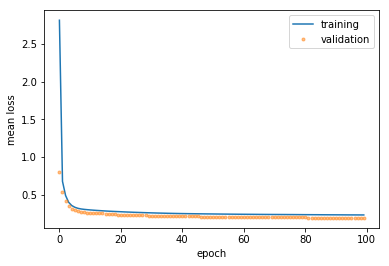

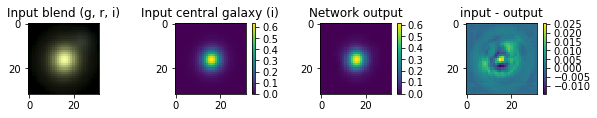

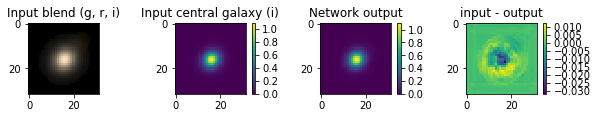

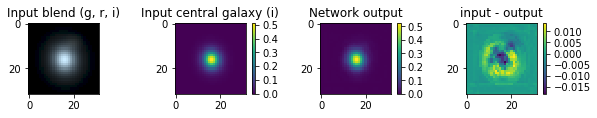

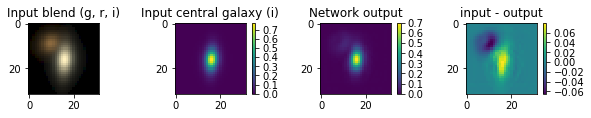

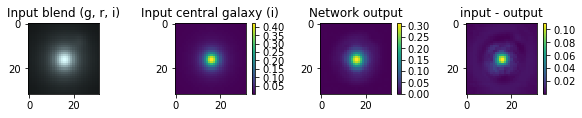

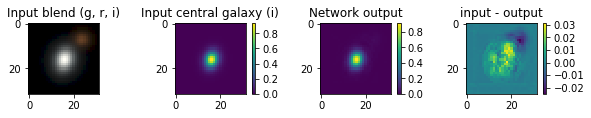

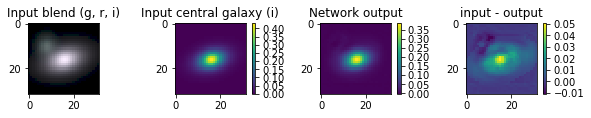

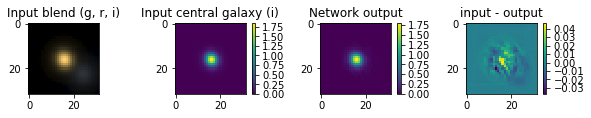

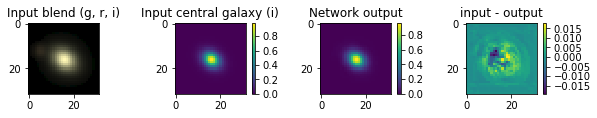

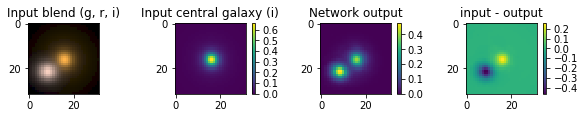

In [6]:
plt.plot(train_loss, label='training')
plt.plot(val_loss, '.', label='validation', alpha=0.5)
plt.ylabel('mean loss')
plt.xlabel('epoch')
plt.legend()
plt.show()
plot_preds(pred, X_val, Y_val)

In [8]:
from astropy.table import Table
path = '/global/projecta/projectdirs/lsst/groups/WL/projects/wl-btf/two_gal_blend_data/training_data/'
filename = os.path.join(path, 'gal_pair_band_wldeb_blend_param.fits')
blend_param = Table.read(filename, format='fits')
diff_val = save_diff_blend(pred, Y_val)

np.random.seed(0)
validation = np.random.choice(2048, int(2048 * 0.1), replace=False)

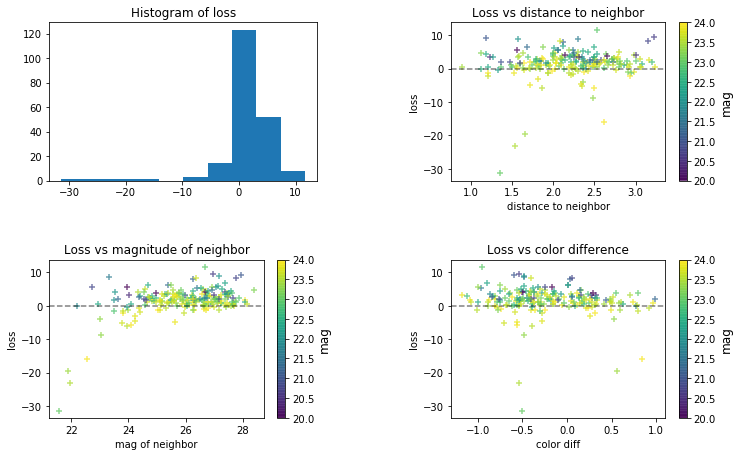

In [9]:
c = blend_param['ab_mag'][validation]

plt.figure(figsize=[12, 16])
plt.subplot(4, 2, 1)
plt.subplots_adjust(wspace = 0.5)
plt.subplots_adjust(hspace = 0.5)
plt.hist(diff_val)
plt.title("Histogram of loss")
plt.subplot(4, 2, 2)
plt.scatter(blend_param[validation]['distance_neighbor'], diff_val,
            c=c, vmin=20, vmax=24, alpha=0.7, marker='+')
cbar = plt.colorbar()
cbar.set_label(label='mag',size=12)
plt.title("Loss vs distance to neighbor")
plt.xlabel('distance to neighbor')
plt.axhline(0, linestyle='--', color='k', alpha=0.5)
plt.ylabel('loss')
plt.subplot(4, 2, 3)
plt.scatter(blend_param[validation]['mag_neighbor'], diff_val,
           c=c, vmin=20, vmax=24, alpha=0.7, marker='+')
cbar = plt.colorbar()
cbar.set_label(label='mag',size=12)
plt.title("Loss vs magnitude of neighbor")
plt.xlabel('mag of neighbor')
plt.ylabel('loss')
plt.axhline(0, linestyle='--', color='k', alpha=0.5)
plt.subplot(4, 2, 4)
plt.scatter(blend_param['color_neighbor'][validation] - blend_param['ri_color'][validation],
            diff_val, c=c, vmin=20, vmax=24, alpha=0.7, marker='+')
cbar = plt.colorbar()
cbar.set_label(label='mag',size=12)
plt.title("Loss vs color difference")
plt.xlabel('color diff')
plt.ylabel('loss')
plt.axhline(0, linestyle='--', color='k', alpha=0.5)
plt.show()